In [1]:
!pip install -r "/kaggle/input/bci-mini-project/requirements.txt"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 669.5 kB/s eta 0:00:000:00:01
  Created wheel for shutils: filename=shutils-0.1.0-py3-none-any.whl size=3274 sha256=5e840c8a8628a6afc025b7fec36f6cdb852174fae373010d6e9d0f2b9124fb5b
  Stored in directory: /root/.cache/pip/wheels/62/63/04/81e549bdb44792d8b62938cffc3bd00a34addabe1da3693db8
Successfully built shutils


In [2]:
%matplotlib inline
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import stft, ricker, cwt, butter, iirnotch, lfilter
import scipy.stats as stats
import pywt
from tqdm import tqdm
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

import torch

import mne

from statsmodels.stats.weightstats import ztest

In [3]:
sample_frequency = 256 #Hz
bandpass_filter = (0, 30) # Hz
stimulus_duration = 125 #ms
interstimulus_interval = 125 #ms
total_stimulus = 12 # 6 rows and 6 columns
number_of_times_each_stimulus_appeared_per_trial = 10
total_stimulus_appeared_per_trial = total_stimulus * number_of_times_each_stimulus_appeared_per_trial

trial_duration = (stimulus_duration * total_stimulus_appeared_per_trial) + \
(interstimulus_interval * (total_stimulus_appeared_per_trial- 1))

samples_per_trial = (sample_frequency * trial_duration)//1000


# Load Data

In [4]:
import os
import pickle

# Folder path
folder_path = '/kaggle/input/bci-mini-project/cleaned_data'

# File paths
x_file_path = os.path.join(folder_path, 'x.pkl')
y_file_path = os.path.join(folder_path, 'y.pkl')

# Load data
with open(x_file_path, 'rb') as f:
    X = pickle.load(f)

with open(y_file_path, 'rb') as f:
    y = pickle.load(f)



In [5]:
X.shape, y.shape

((8, 7, 5, 7648, 8), (8, 7, 5, 7648))

X: patients, number_of_run, number_of_trials_per_run, samples of signals, channels

y_target: patients, number_of_run, number_of_trials_per_run, samples

# Extract feature

In [6]:
def create_data(x,y,show_progress=False,get_delayed_samples=0):
    """
    Input X: (patients, number_of_run, number_of_trials_per_run, samples of signals, channels)
    Input y: patients, number_of_run, number_of_trials_per_run, samples
    Output X: (Data, samples, channels)
    Output y: (Data, samples)
    """
    x=x.reshape ((x.shape[0],x.shape[1]*x.shape[2]*x.shape[3],x.shape[4]))
    y=y.reshape ((y.shape[0],y.shape[1]*y.shape[2]*y.shape[3]))

    x_output=[]
    y_output=[]

    waveform_start_time_after_onset = 0
    waveform_start_sample_after_onset = int(sample_frequency * waveform_start_time_after_onset / 1000)
    
    stimulus_samples = 256*stimulus_duration//1000
    waveform_end_sample_after_onset = stimulus_samples + get_delayed_samples

    for patient in range(x.shape[0]):
        val = range(x.shape[1])
        if show_progress:
            val = tqdm(val)
        for sample in val:
            if (y[patient, sample] != 0) and  (y[patient, sample-1] != y[patient, sample]): # start of onset
                if sample + waveform_end_sample_after_onset < y.shape[-1]:
                    x_output.append(x[patient, sample+waveform_start_sample_after_onset:sample+waveform_end_sample_after_onset, :])
                    y_output.append(y[patient, sample])
    
    return np.array(x_output), np.array(y_output)

In [7]:
samples_per_class = 17*12
additional_samples = samples_per_class - (256*stimulus_duration//1000)
x, y = create_data(X,y,show_progress=True, get_delayed_samples=additional_samples)


100%|██████████| 267680/267680 [00:00<00:00, 544146.67it/s]


In [8]:
x = x.transpose((0, 2, 1))
y=y-1
x = x.reshape((x.shape[0], x.shape[1], 17, 12)).mean(axis=-1)
x, y = shuffle(x, y, random_state=12432)
X_data = x.copy()
y_data = y.copy()
x = x.reshape((x.shape[0], -1))
print(x.shape)

(33576, 136)


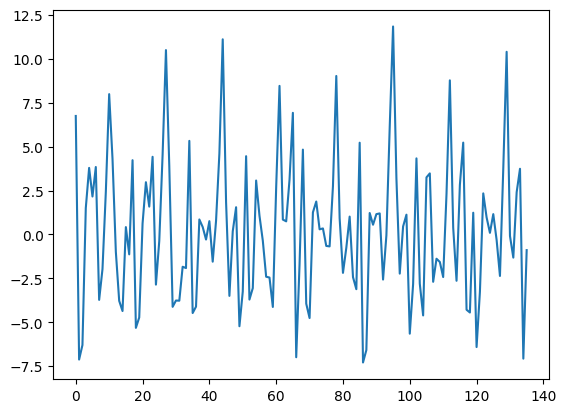

In [9]:
plt.figure()
plt.plot(x[2, :])
plt.show()

In [10]:
np.unique(y)

array([0, 1], dtype=uint8)

In [11]:
# Balancing the dataset
data_per_class = 5600
indices = np.concatenate((np.where(y == 0)[0][:data_per_class], np.where(y == 1)[0][:data_per_class]))
x = x[indices, :]
y = y[indices]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6150)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8960, 136) (8960,) (2240, 136) (2240,)


# PCA

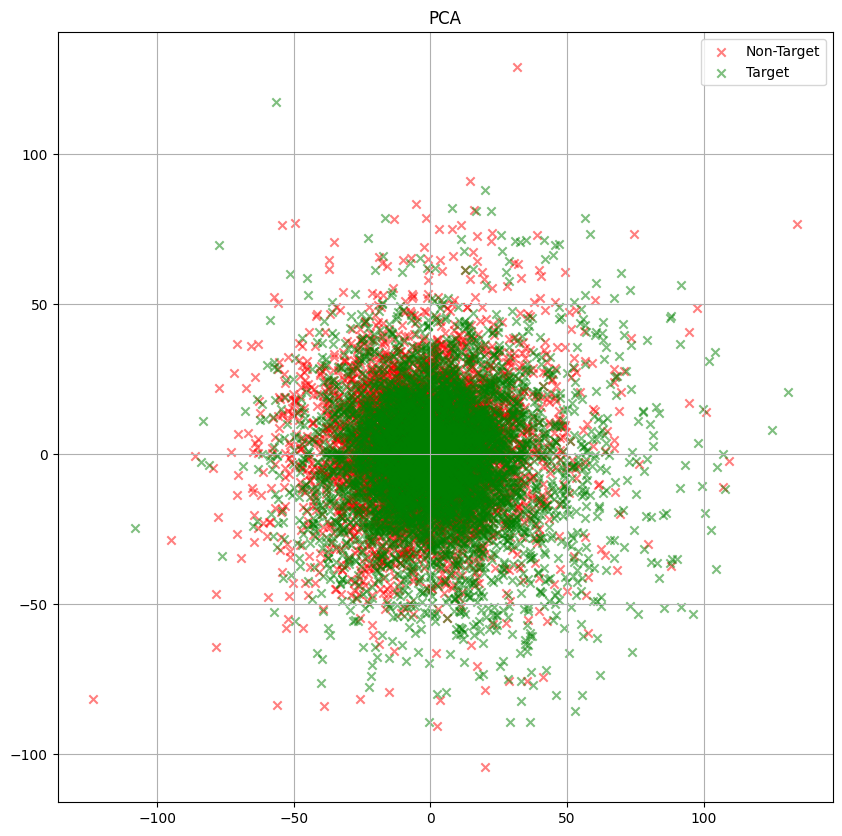

In [13]:

a =  PCA(n_components=2).fit(x).transform(x)
plt.figure(figsize=(10, 10))
plt.title("PCA")
plt.scatter(a[y == 0, 0], a[y == 0, 1], label='Non-Target', color='r', alpha=0.5, marker='x')
plt.scatter(a[y == 1, 0], a[y == 1, 1], label='Target', color='g', alpha=0.5, marker='x')
plt.grid()
plt.legend()
plt.show()

# Stepwise LDA

In [14]:
class StepwiseLDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.classes = []
        self.eigenpairs = []
        self.weights = None
        
    def transform(self, x):
        if self.weights is None:
            raise ValueError("Please fit the model before using it")
            
        return x.dot(self.weights)
        
        
        
    def fit(self, x, y):
        self.classes = np.unique(y)
        
        # Calculate mean vectors
        mean_vectors = []
        for c in self.classes:
            mean_vectors.append(np.mean(x[y == c], axis=0))
        mean_vectors = np.array(mean_vectors)
        
        
        
        s_w = np.zeros((x.shape[1],x.shape[1]))  # Create scatter within matrix for each feature
        s_b = np.zeros((x.shape[1],x.shape[1]))  # Between Class Scatter Matrix
        overall_mean = np.mean(x, axis=0).reshape(x.shape[1],1)  # Mean for all classes
        
        for cl, mv in zip(self.classes, mean_vectors):  # For each class and its corresponding mean vector
            mv = mv.reshape(x.shape[1],1) # transpose mean vector of the current class
            x_target = x[y==cl]  # Calculate size/total no. of feature vectors in the current class
            n = x_target.shape[0]
            
            # Calculate within-class Scatter matrix
            class_sc_mat = np.zeros((x.shape[1],x.shape[1]))                  # scatter matrix for every class
            for row in x_target:
                row = row.reshape(x.shape[1],1) # make column vectors
                class_sc_mat += (row-mv).dot((row-mv).T)
            
            s_w += class_sc_mat                             # sum class scatter matrices
            
            # calculate between-class scatter matrix            
            s_b += n * (mv - overall_mean).dot((mv - overall_mean).T)  # Calculate Between class scatter matrix
            
        # Compute Eigen Value and Eigenvector for the dot product between the two matrices
        eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(s_w).dot(s_b))
        
        
        # Make a list of (eigenvalue, eigenvector) tuples
        self.eigenpairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        self.eigenpairs = sorted(self.eigenpairs, key=lambda k: k[0], reverse=True)
        
        # Calculate weights
        self.weights = self.eigenpairs[0][1].reshape(x.shape[1],1)
        #W = np.hstack((, eig_pairs[1][1].reshape(x_tr_an.shape[1],1)))
        for i in range(1, self.n_components):
            self.weights = np.hstack((self.weights, self.eigenpairs[i][1].reshape(x.shape[1],1)))
            
        return self

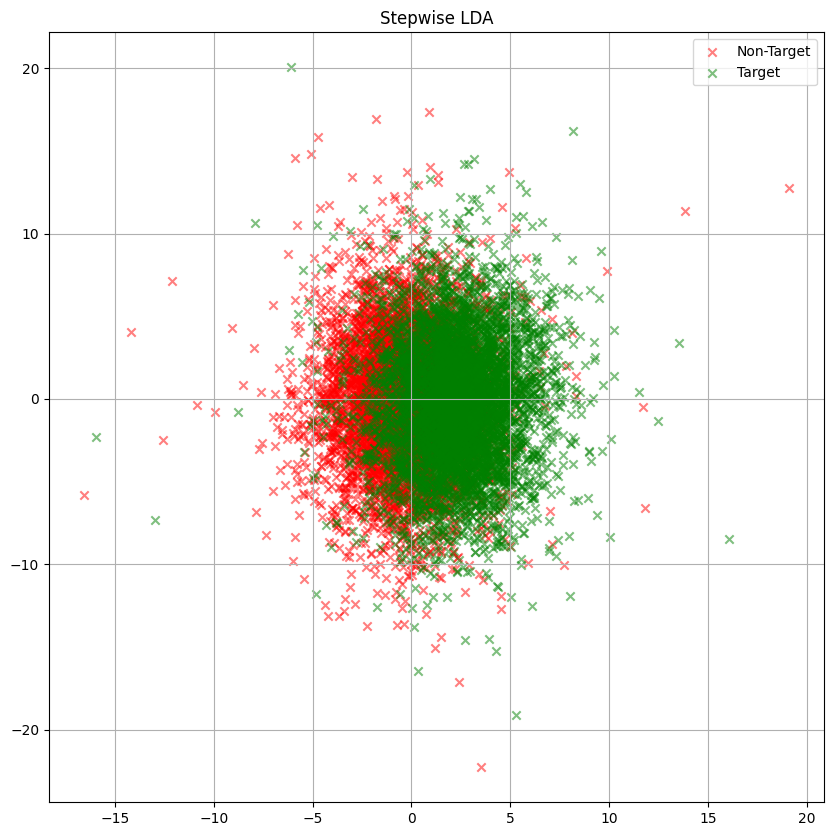

In [15]:
a =  StepwiseLDA(n_components=2).fit(x, y).transform(x)
plt.figure(figsize=(10, 10))
plt.title("Stepwise LDA")
plt.scatter(a[y == 0, 0].real, a[y == 0, 1].real, label='Non-Target', color='r', alpha=0.5, marker='x')
plt.scatter(a[y == 1, 0].real, a[y == 1, 1].real, label='Target', color='g', alpha=0.5, marker='x')
plt.grid()
plt.legend()
plt.show()

In [16]:
clf = RandomForestClassifier(max_depth=2, random_state=26784)
clf.fit(X_train, y_train)
print(f"Accuracy: {clf.score(X_test, y_test)*100:.5f}%")

Accuracy: 59.24107%


In [17]:
clf = RandomForestClassifier(max_depth=35, random_state=26784)
clf.fit(X_train, y_train)
print(f"Accuracy: {clf.score(X_test, y_test)*100:.5f}%")

Accuracy: 65.53571%


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


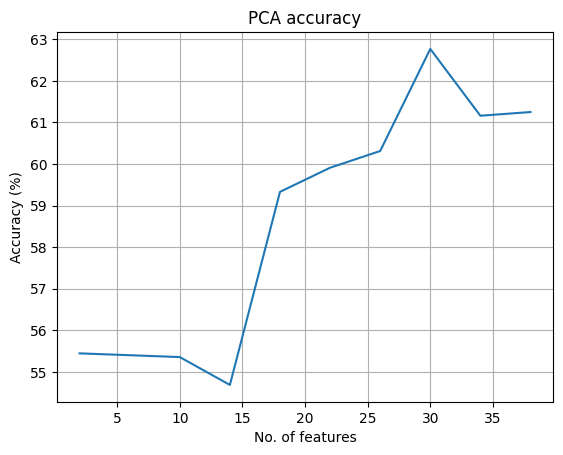

In [18]:
input_features = np.arange(2, 42, 4)
accuracies = []

for f in tqdm(input_features):
    pca = PCA(n_components=f)
    pca.fit(X_train, y_train)
    a, b = pca.transform(X_train), pca.transform(X_test)
    clf = RandomForestClassifier(max_depth=2, random_state=26784)
    clf.fit(a, y_train)
    accuracies.append(clf.score(b, y_test)*100)

    
plt.figure()
plt.title("PCA accuracy")
plt.plot(input_features, accuracies)
plt.grid()
plt.xlabel("No. of features")
plt.ylabel("Accuracy (%)")
plt.show()

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


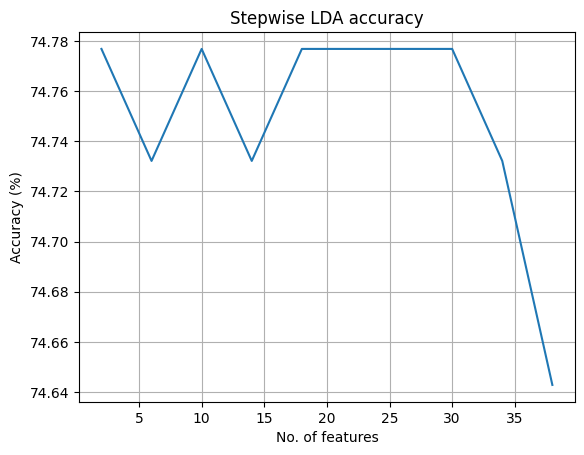

In [19]:
input_features = np.arange(2, 42, 4)
accuracies = []

for f in tqdm(input_features):
    lda = StepwiseLDA(f)
    lda.fit(X_train, y_train)
    a, b = lda.transform(X_train), lda.transform(X_test)
    clf = RandomForestClassifier(max_depth=2, random_state=26784)
    clf.fit(a.real, y_train)
    accuracies.append(clf.score(b.real, y_test)*100)

    
plt.figure()
plt.title("Stepwise LDA accuracy")
plt.plot(input_features, accuracies)
plt.grid()
plt.xlabel("No. of features")
plt.ylabel("Accuracy (%)")
plt.show()

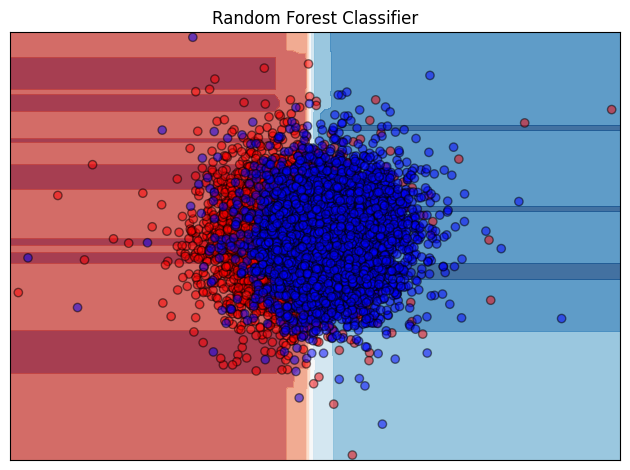

In [20]:
a =  StepwiseLDA(n_components=2).fit(x, y).transform(x)
clf = RandomForestClassifier(max_depth=2, random_state=26784)
clf.fit(a.real, y)
    
plt.figure()

ax = plt.subplot(1, 1, 1)
ax.set_title("Random Forest Classifier")

DecisionBoundaryDisplay.from_estimator(
            clf, a.real, cmap=plt.cm.RdBu, alpha=0.8, ax=ax, eps=0.5
        )

ax.scatter(a[:, 0].real, a[:, 1].real, c=y, alpha=0.5, edgecolors="k", cmap=ListedColormap(["#FF0000", "#0000FF"]))

x_min, x_max = a[:, 0].real.min() - 0.5, a[:, 0].real.max() + 0.5
y_min, y_max = a[:, 1].real.min() - 0.5, a[:, 1].real.max() + 0.5
    
ax.set_xlim(x_min, x_max)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())


plt.tight_layout()
plt.show()

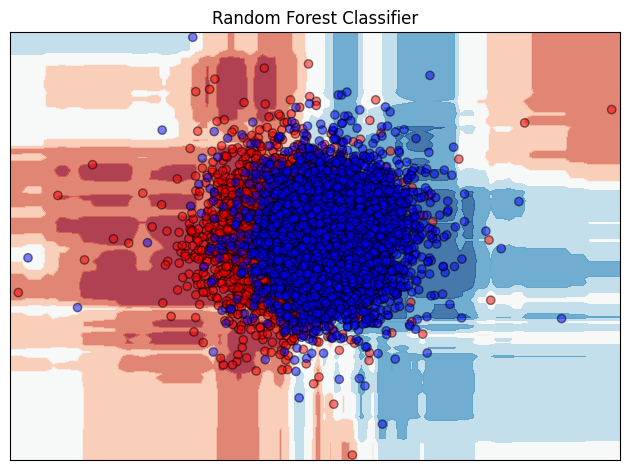

In [21]:
a =  StepwiseLDA(n_components=2).fit(x, y).transform(x)
clf = RandomForestClassifier(max_depth=10, random_state=26784)
clf.fit(a.real, y)
    
plt.figure()

ax = plt.subplot(1, 1, 1)
ax.set_title("Random Forest Classifier")

DecisionBoundaryDisplay.from_estimator(
            clf, a.real, cmap=plt.cm.RdBu, alpha=0.8, ax=ax, eps=0.5
        )

ax.scatter(a[:, 0].real, a[:, 1].real, c=y, alpha=0.5, edgecolors="k", cmap=ListedColormap(["#FF0000", "#0000FF"]))

x_min, x_max = a[:, 0].real.min() - 0.5, a[:, 0].real.max() + 0.5
y_min, y_max = a[:, 1].real.min() - 0.5, a[:, 1].real.max() + 0.5
    
ax.set_xlim(x_min, x_max)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())


plt.tight_layout()
plt.show()

In [22]:
x_target = X_data[np.where(y_data == 1)[0]]
x_nontarget = X_data[np.where(y_data == 0)[0]]
print(x_target.shape)

(5600, 8, 17)


In [23]:

X_train, X_test = torch.tensor(X_train, requires_grad=False).float(), torch.tensor(X_test, requires_grad=False).float()
y_train, y_test = torch.tensor(y_train, requires_grad=False).type(torch.LongTensor), torch.tensor(y_test, requires_grad=False).type(torch.LongTensor)

In [24]:
@torch.no_grad()
def calculate_accuracy(prediction, true_labels):
    prediction_classes = torch.argmax(prediction, axis=1)
    return (prediction_classes == true_labels).float().mean()

def train(epochs, batch_size, loss_function, optimizer, model, x, y, print_every=200, learning_rate_decay=None):
    train_accuracy = []
    train_loss = []
    vals = tqdm(range(epochs), desc=f'Epoch: 0, train loss: -, Accuracy: -')
    
    scheduler = None
    if not (learning_rate_decay is None):
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learning_rate_decay)
    
    for epoch in vals:
        avg_cost = 0
    
        # Shuffle training data
        dataset = torch.randperm(x.shape[0])
        
        # For each batch
        for batch in range(0, dataset.size()[0], batch_size):
            model.train()
            
            range_end = batch+batch_size
            if range_end + batch_size >= dataset.size()[0]:
                range_end = range_end+batch_size
            # Get train and test data
            x_batch = x[dataset[batch:range_end]]
            y_batch = y[dataset[batch:range_end]]
            
            # Forward pass
            optimizer.zero_grad()
            prediction = model(x_batch)
            
            # Calculate loss
            loss = loss_function(prediction, y_batch)

            # Backpropagation
            loss.backward() # Calculate gradient
            optimizer.step() # Upgrade gradients
            
        
            # Calculate metrics
            train_loss.append(loss.item())
            train_accuracy.append(calculate_accuracy(prediction, y_batch))
            
            if batch % print_every == 0:
                vals.set_description(f'Epoch: {epoch}, train loss: {train_loss[-1]:.5f}, Accuracy: {train_accuracy[-1]*100:3f}')
                
        if not (scheduler is None):
            scheduler.step() # Learning rate decay
                
    return train_loss, train_accuracy

In [25]:
class ModelDNN(torch.nn.Module):
    def __init__(self, sample_x, total_classes, first_layer_neuron=1024, hidden_layers_neurons=[512, ], activation=torch.nn.ReLU):
        super(ModelDNN, self).__init__()
        
        # Reshape signal so that it has only two dimenstions: 
        sample_x = self.get_valid_x(sample_x)
        print(f"Layer 1 input: {sample_x.shape}")
        
        # Layer 1- Fully Connected layer
        self.fc1 = torch.nn.Linear(sample_x.shape[-1], first_layer_neuron)
        self.act1 = activation()
        self.drop1 = torch.nn.Dropout(0.4)
        
        self.layer1 = torch.nn.Sequential(self.fc1, self.act1, self.drop1)
        
        self.layer1.eval()
        with torch.no_grad():
            out = self.layer1(sample_x)
            print(f"Layer 1 output: {out.shape}")
        self.layer1.train()
        
        self.layers = torch.nn.ModuleList()
        self.layers.append(self.layer1)
        self.activation_layer_name = [type(self.act1).__name__]
        
        # Add additional hidden layers
        for i in range(len(hidden_layers_neurons)):
            hidden_fc = torch.nn.Linear(out.shape[-1], hidden_layers_neurons[i])
            hidden_act = activation()
            hidden_drop = torch.nn.Dropout(0.2)
            hidden_layer = torch.nn.Sequential(hidden_fc, hidden_act, hidden_drop)
            
            hidden_layer.eval()
            with torch.no_grad():
                out = hidden_layer(out)
                print(f"Layer {i+2} output: {out.shape}")
            hidden_layer.train()
            self.layers.append(hidden_layer)
            self.activation_layer_name.append(type(hidden_act).__name__)
            
        # Add output layer
        self.out_fc = torch.nn.Linear(out.shape[1], total_classes, bias=False)
        
        self.out_fc.eval()
        with torch.no_grad():
            out = self.out_fc(out)
            print(f"Final output: {out.shape}")
        self.out_fc.train()
        
    def forward(self, x):
        out = self.get_valid_x(x)
        
        for layer in self.layers:
            out = layer(out)
            
        return self.out_fc(out)
            
            
    def get_valid_x(self, x):
        if len(x.shape) > 2:
            x = x.reshape((x.shape[0], -1))
        return x
    
    def show_weight_distribution(self):
        params = []
        for param in self.parameters():
            if len(param.shape) >= 2:
                params.append(param)
        cols = 2
        rows = len(params)/2
        if int(rows) != rows:
            rows = int(rows) + 1
        else:
            rows = int(rows)

        fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
        plt.suptitle("Weight Distribution")

        current = 0
        for i in range(rows):
            for j in range(cols):
                if current >= len(params):
                    break
                ax[i, j].set_title(f"Param: {current+1}")
                ax[i, j].hist(params[current].detach().numpy().reshape(-1))
                ax[i, j].grid()
                current += 1


        plt.subplots_adjust(hspace=0.5)
        plt.show()
        
    
    def show_weights(self):
        self.eval()
        with torch.no_grad():
            cols = 2
            rows = len(model.layers)/cols
            if rows == int(rows):
                rows = int(rows)
            else:
                rows = int(rows) + 1

            fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
            plt.suptitle("Layer Weights")

            current = 0
            current_i = 0
            current_j = 0
            for layer in self.layers:
                if current >= len(model.layers):
                    break
                params = layer.parameters()
                for p in params:
                    if current >= len(model.layers):
                        break
                    if len(p.shape) == 2:
                        weights = p.numpy()
                        ax[current_i, current_j].set_title(f"Weight - Layer {current+1}")
                        im = ax[current_i, current_j].pcolormesh(weights, cmap='gray')
                        fig.colorbar(im, ax=ax[current_i, current_j], orientation='vertical')
                        
                        # Draw vertical line where neurons are dead
                        zeros = np.where(np.sum(weights) == 0)[0]
                        for ind in zeros:
                            ax[current_i, current_j].axvline(x=ind, color='b')
                        current += 1
                        if current_j + 1 >= cols:
                            current_j = 0
                            current_i += 1
                        else:
                            current_j += 1

            
            plt.subplots_adjust(hspace=0.5)
            plt.show()
            
        self.train()
        
        
        
        
    
    def show_output_distribution(self, x):
        self.eval()
        with torch.no_grad():
            out = self.get_valid_x(x)
            activated_outs = []
            for i in range(len(self.layers)):
                module = self.layers[i]
                for layer in module:
                    out = layer(out)
                    if type(layer).__name__ == self.activation_layer_name[i]:
                        activated_outs.append(out)
                
            cols = 2
            rows = len(activated_outs)/2
            if int(rows) != rows:
                rows = int(rows) + 1
            else:
                rows = int(rows)

            fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
            plt.suptitle("Activated Output distribution")
            
            current = 0
            for i in range(rows):
                for j in range(cols):
                    if current >= len(activated_outs):
                        break
                    ax[i, j].set_title(f"Output: {current+1}")
                    ax[i, j].hist(activated_outs[current].detach().numpy().reshape(-1))
                    ax[i, j].grid()
                    current += 1


            plt.subplots_adjust(hspace=0.5)
            plt.show()
            
            
        self.train()


Layer 1 input: torch.Size([2240, 136])
Layer 1 output: torch.Size([2240, 512])
Layer 2 output: torch.Size([2240, 128])
Layer 3 output: torch.Size([2240, 64])
Layer 4 output: torch.Size([2240, 32])
Layer 5 output: torch.Size([2240, 16])
Final output: torch.Size([2240, 2])


Epoch: 49, train loss: 0.29760, Accuracy: 75.000000: 100%|██████████| 50/50 [05:52<00:00,  7.05s/it] 


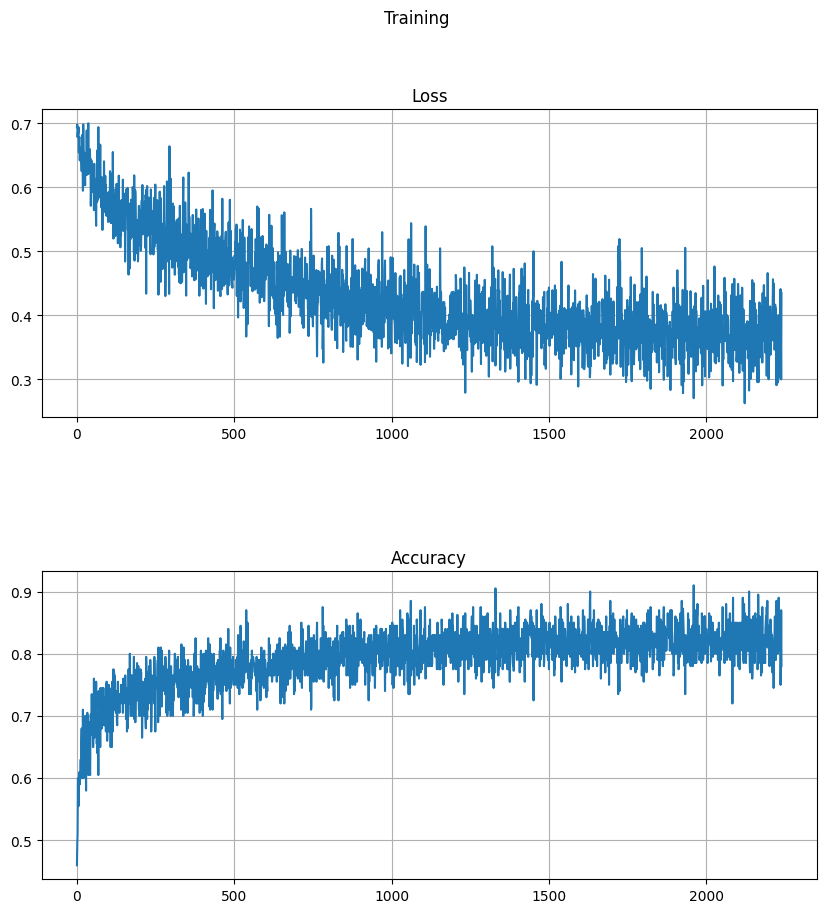

In [52]:
model = ModelDNN(X_test, np.unique(y_test).size, first_layer_neuron=512, hidden_layers_neurons=[128, 64, 32, 16])
epochs = 50
batch_size = 4
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=X_train,
    y=y_train,
    print_every=200,
    learning_rate_decay=0.9
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [53]:
with torch.no_grad():
    print(f"Accuracy: {calculate_accuracy(model(X_test), y_test)*100:.3f}%")

Accuracy: 72.857%


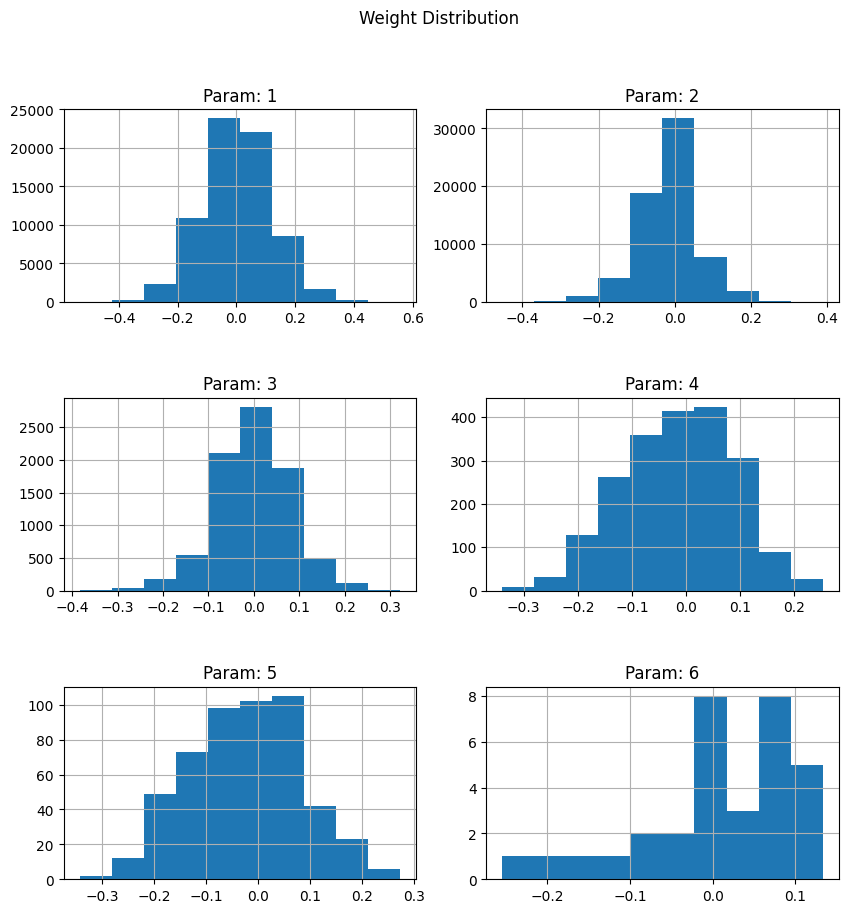

In [54]:
model.show_weight_distribution()

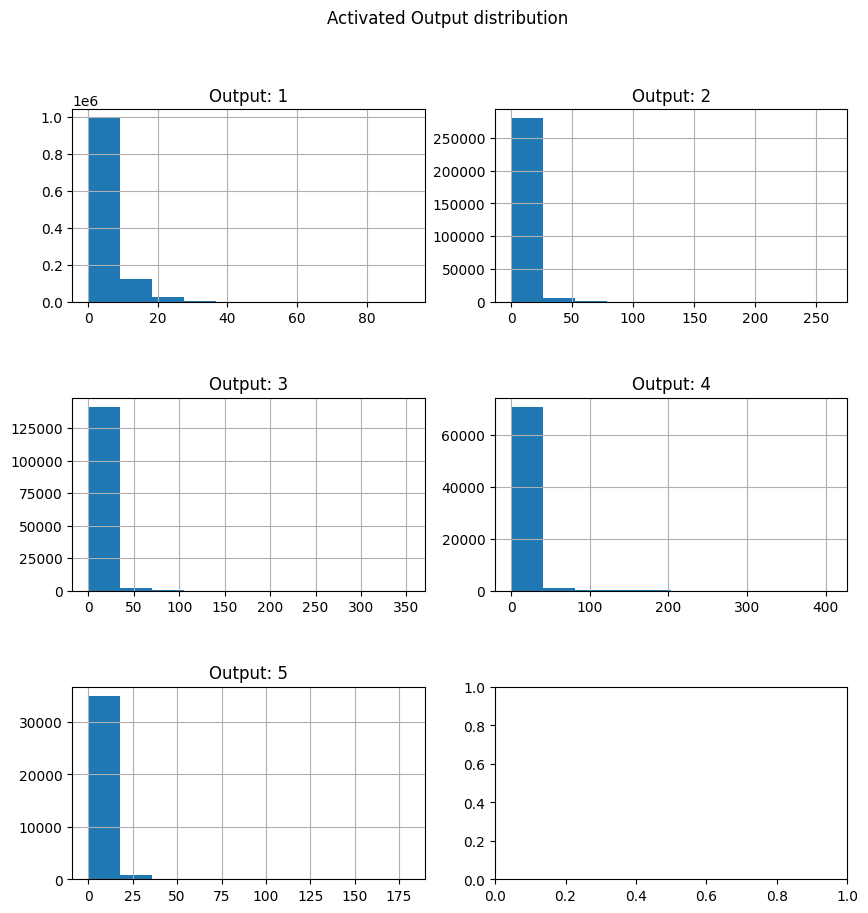

In [55]:
model.show_output_distribution(X_test)

Epoch: 49, train loss: 0.26040, Accuracy: 75.000000: 100%|██████████| 50/50 [04:34<00:00,  5.49s/it] 


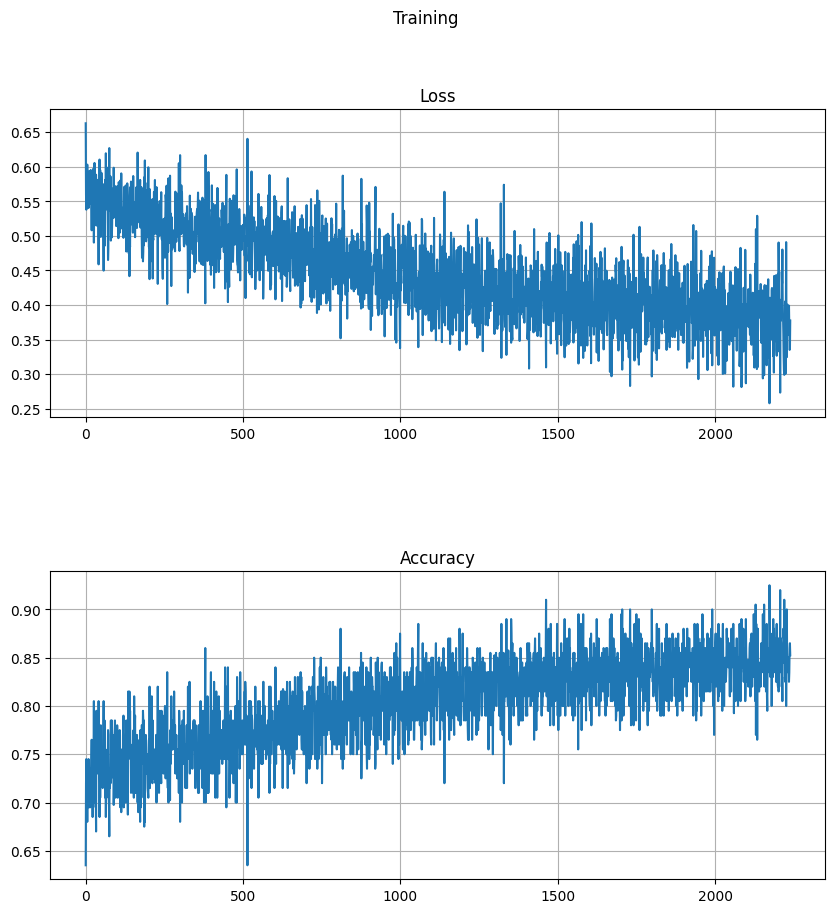

In [30]:
lda = StepwiseLDA(n_components=35)
lda.fit(X_train.numpy(), y_train.numpy())
model = ModelDNN(
    torch.tensor(lda.transform(X_test.numpy()).real).float(), 
    np.unique(y_test.numpy()).size, 
    first_layer_neuron=512, 
    hidden_layers_neurons=[128, 64, 32, 16],
    activation=torch.nn.Tanh
)
epochs = 50
batch_size = 4
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=torch.tensor(lda.transform(X_train.numpy()).real).float(),
    y=y_train,
    print_every=200,
    learning_rate_decay=0.95
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [31]:
with torch.no_grad():
    print(f"Accuracy: {calculate_accuracy(model(torch.tensor(lda.transform(X_test.numpy()).real).float()), y_test)*100:.3f}%")

Accuracy: 69.643%


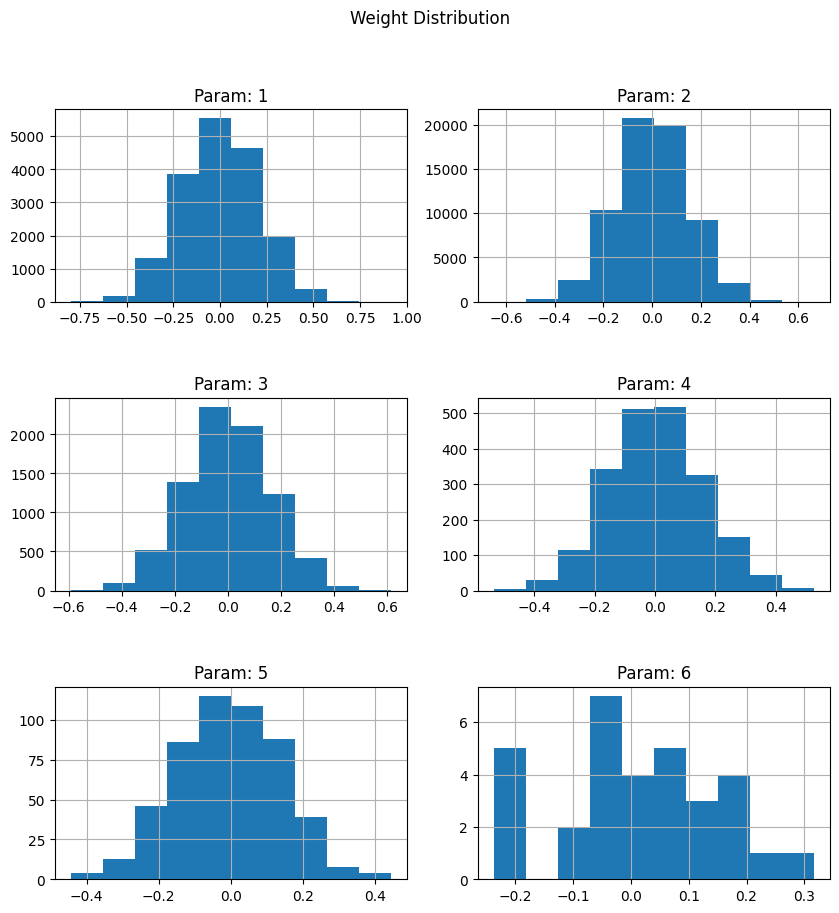

In [32]:
model.show_weight_distribution()

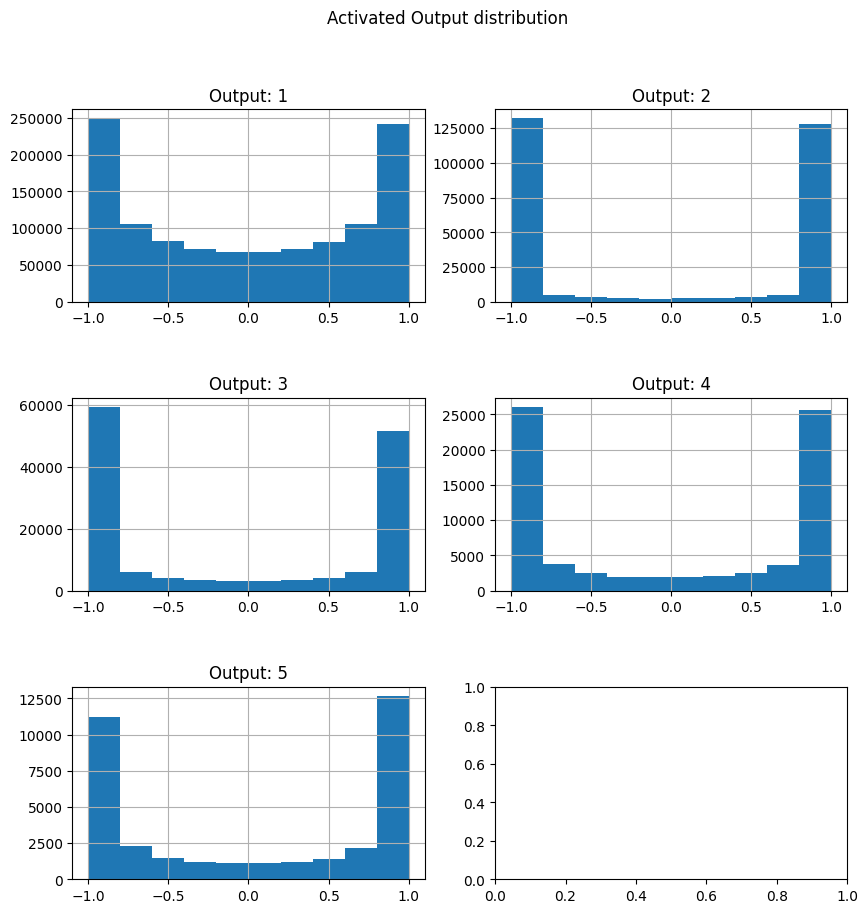

In [33]:
model.show_output_distribution(torch.tensor(lda.transform(X_test.numpy()).real).float())


Layer 1 input: torch.Size([2240, 136])
Layer 1 output: torch.Size([2240, 512])
Layer 2 output: torch.Size([2240, 256])
Layer 3 output: torch.Size([2240, 128])
Layer 4 output: torch.Size([2240, 64])
Layer 5 output: torch.Size([2240, 32])
Layer 6 output: torch.Size([2240, 16])
Final output: torch.Size([2240, 2])


Epoch: 49, train loss: 0.09488, Accuracy: 100.000000: 100%|██████████| 50/50 [08:20<00:00, 10.01s/it]


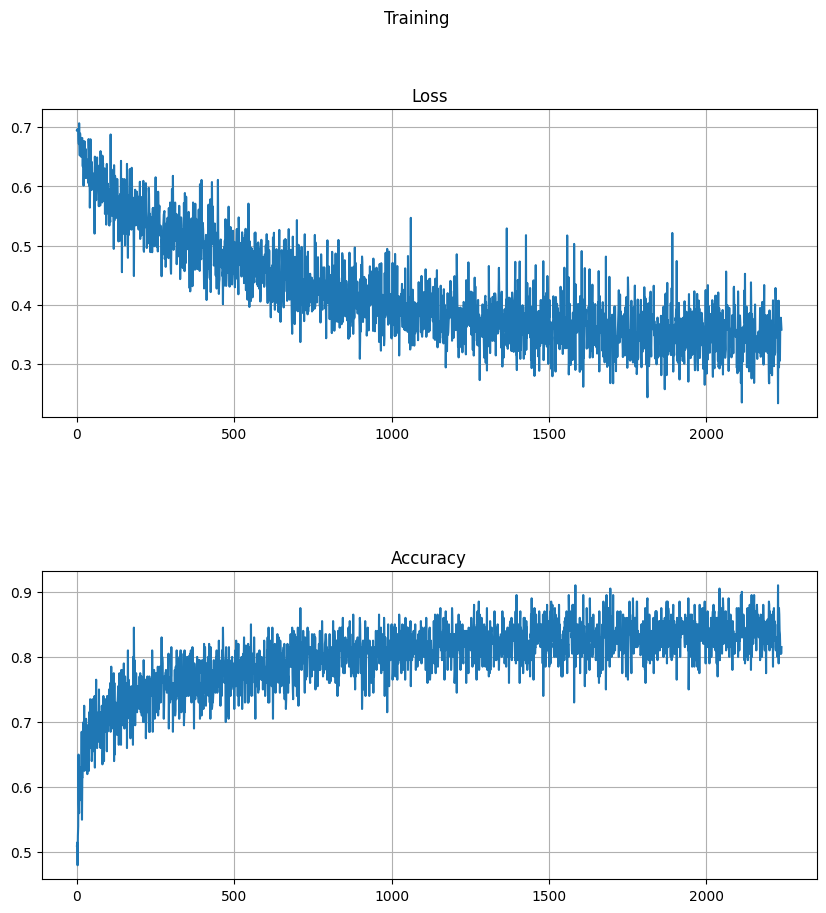

In [34]:
model = ModelDNN(X_test, np.unique(y_test).size, first_layer_neuron=512, hidden_layers_neurons=[256,128, 64, 32, 16])
epochs = 50
batch_size = 4
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=X_train,
    y=y_train,
    print_every=200,
    learning_rate_decay=0.9
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [35]:
with torch.no_grad():
    print(f"Accuracy: {calculate_accuracy(model(X_test), y_test)*100:.3f}%")

Accuracy: 72.321%


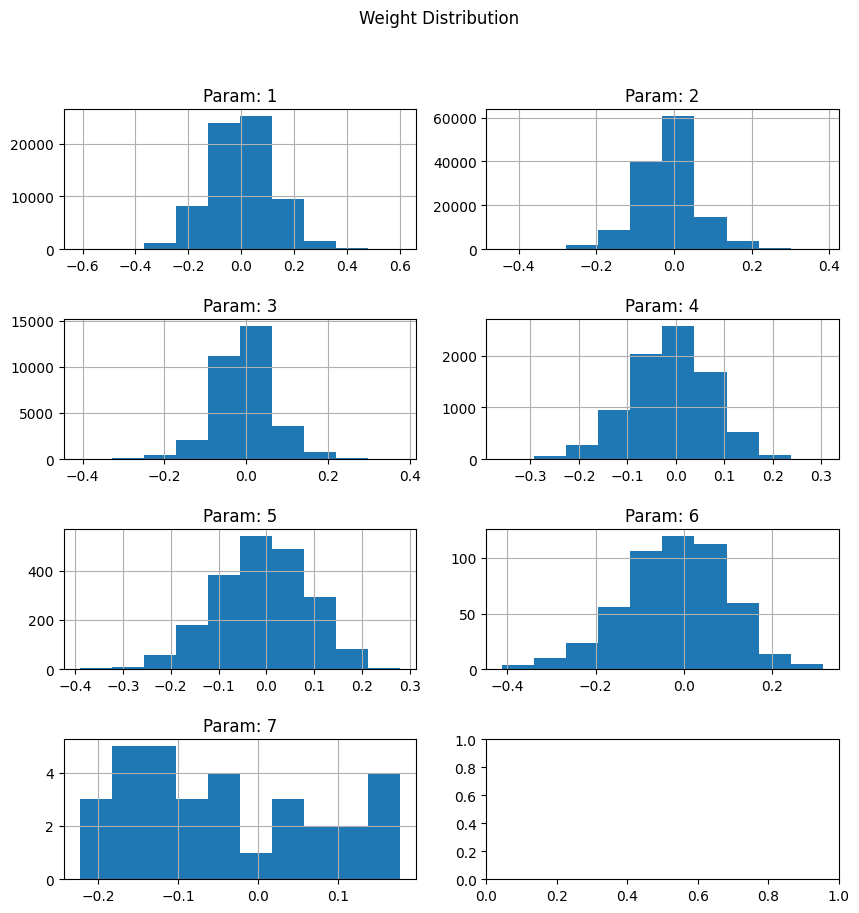

In [36]:
model.show_weight_distribution()

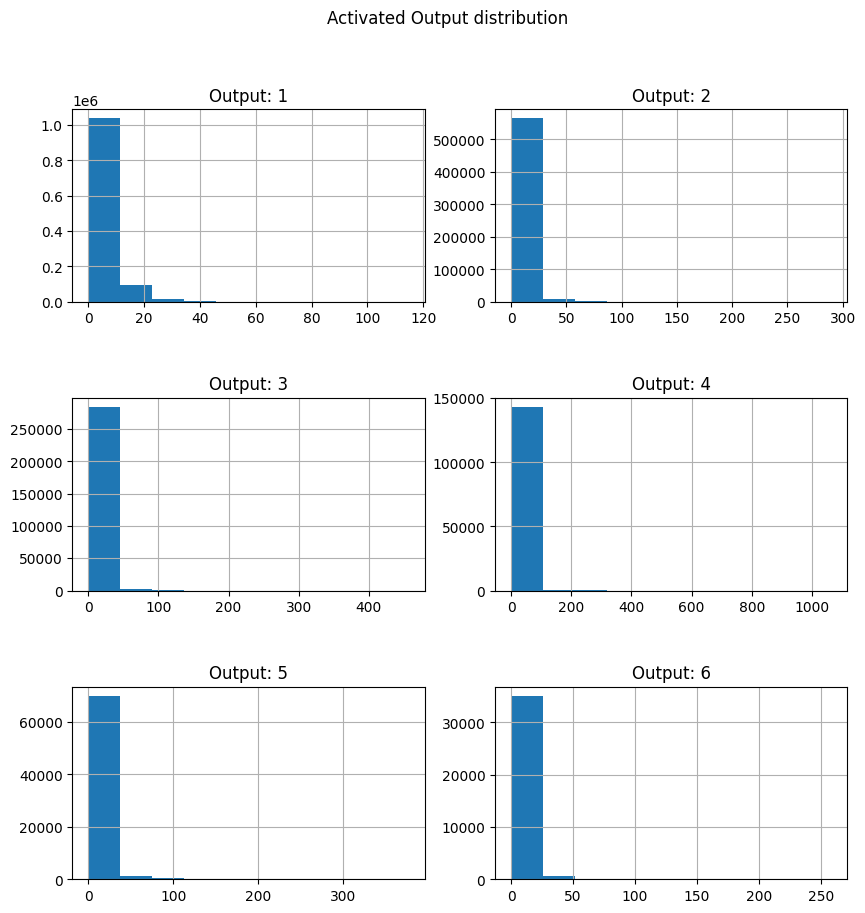

In [37]:
model.show_output_distribution(X_test)

Layer 1 input: torch.Size([2240, 35])
Layer 1 output: torch.Size([2240, 512])
Layer 2 output: torch.Size([2240, 256])
Layer 3 output: torch.Size([2240, 128])
Layer 4 output: torch.Size([2240, 64])
Layer 5 output: torch.Size([2240, 32])
Layer 6 output: torch.Size([2240, 16])
Final output: torch.Size([2240, 2])


Epoch: 49, train loss: 2.01935, Accuracy: 25.000000: 100%|██████████| 50/50 [05:39<00:00,  6.78s/it] 


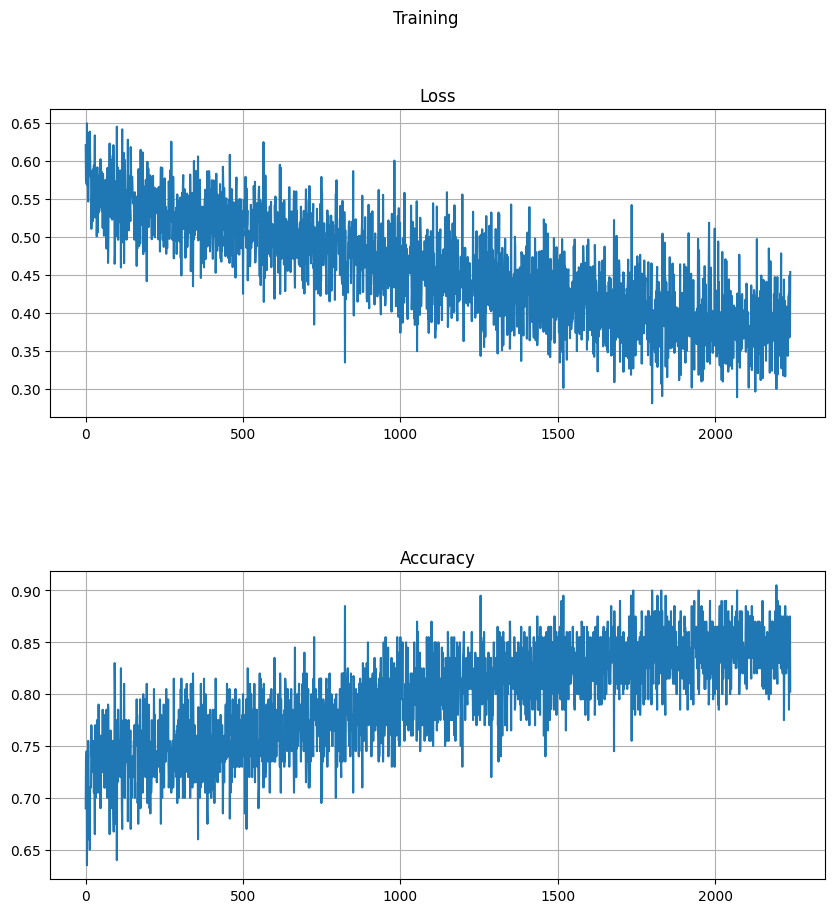

In [38]:
lda = StepwiseLDA(n_components=35)
lda.fit(X_train.numpy(), y_train.numpy())
model = ModelDNN(
    torch.tensor(lda.transform(X_test.numpy()).real).float(), 
    np.unique(y_test.numpy()).size, 
    first_layer_neuron=512, 
    hidden_layers_neurons=[256,128, 64, 32, 16],
    activation=torch.nn.Tanh
)
epochs = 50
batch_size = 4
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=torch.tensor(lda.transform(X_train.numpy()).real).float(),
    y=y_train,
    print_every=200,
    learning_rate_decay=0.95
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [39]:
with torch.no_grad():
    print(f"Accuracy: {calculate_accuracy(model(torch.tensor(lda.transform(X_test.numpy()).real).float()), y_test)*100:.3f}%")

Accuracy: 70.625%


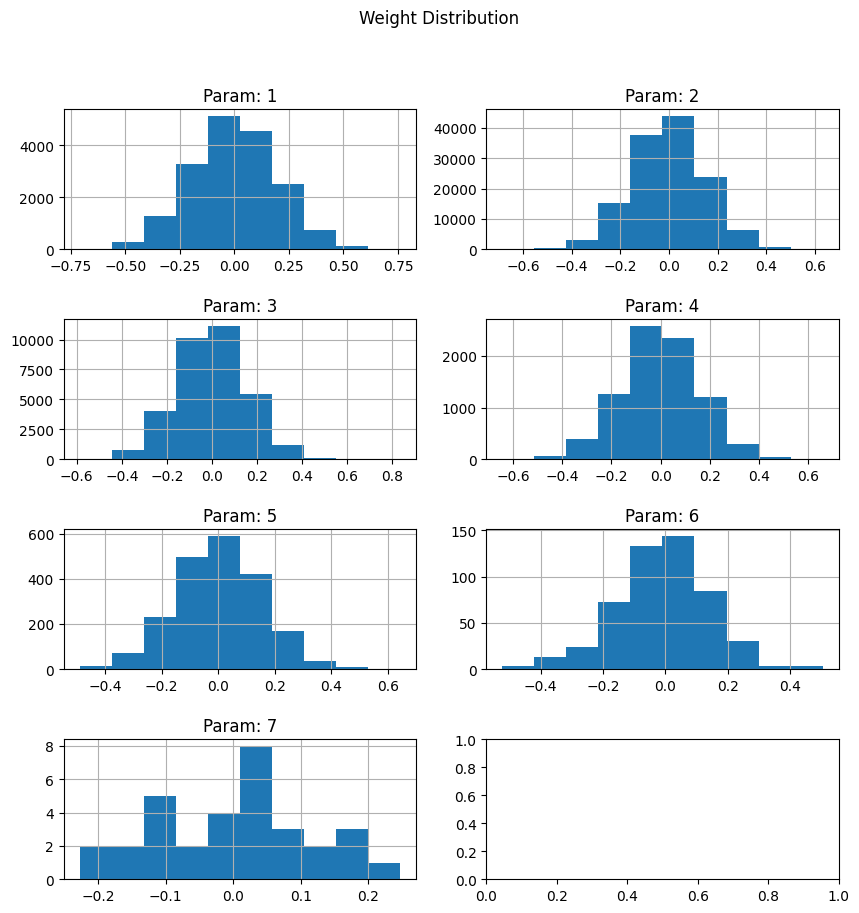

In [40]:
model.show_weight_distribution()

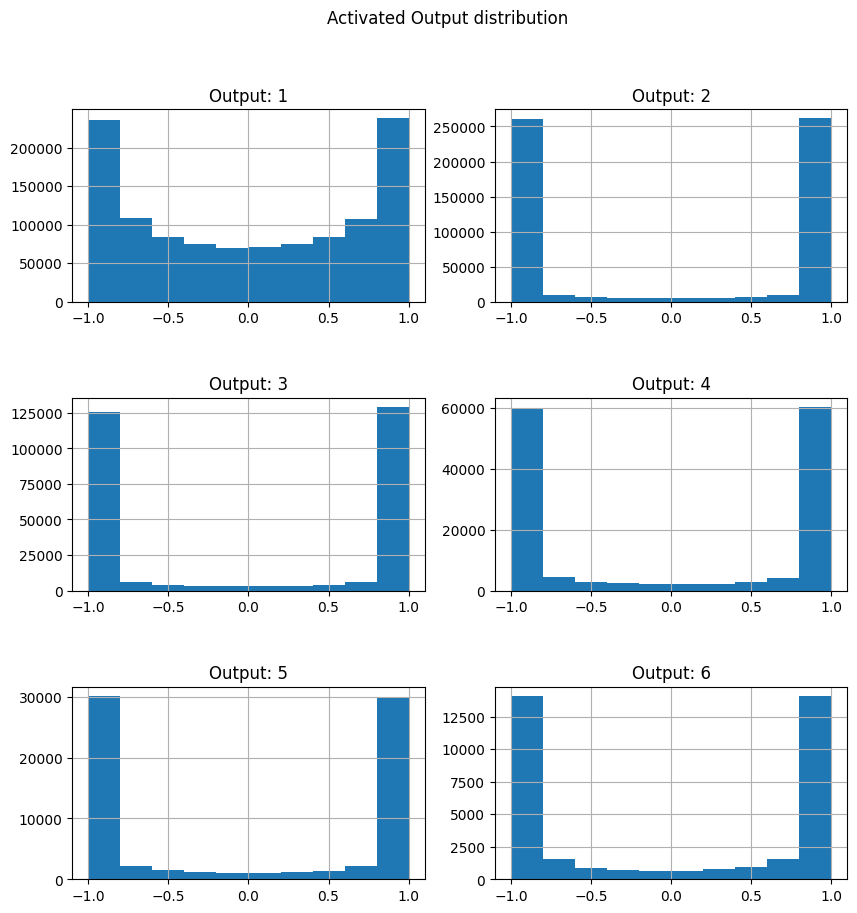

In [41]:
model.show_output_distribution(torch.tensor(lda.transform(X_test.numpy()).real).float())


Layer 1 input: torch.Size([2240, 136])
Layer 1 output: torch.Size([2240, 512])
Layer 2 output: torch.Size([2240, 256])
Layer 3 output: torch.Size([2240, 128])
Layer 4 output: torch.Size([2240, 64])
Layer 5 output: torch.Size([2240, 32])
Layer 6 output: torch.Size([2240, 16])
Final output: torch.Size([2240, 2])


Epoch: 49, train loss: 0.25133, Accuracy: 100.000000: 100%|██████████| 50/50 [18:01<00:00, 21.63s/it]


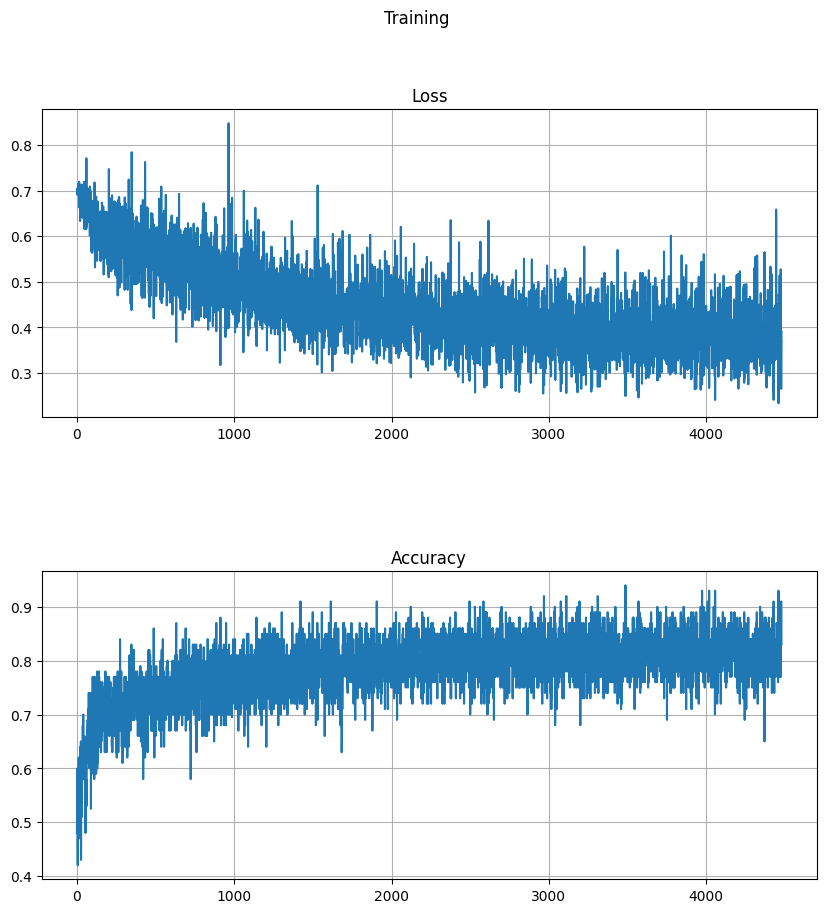

In [42]:
model = ModelDNN(X_test, np.unique(y_test).size, first_layer_neuron=512, hidden_layers_neurons=[256,128, 64, 32, 16])
epochs = 50
batch_size = 2
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=X_train,
    y=y_train,
    print_every=200,
    learning_rate_decay=0.9
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [43]:
with torch.no_grad():
    print(f"Accuracy: {calculate_accuracy(model(X_test), y_test)*100:.3f}%")

Accuracy: 73.839%


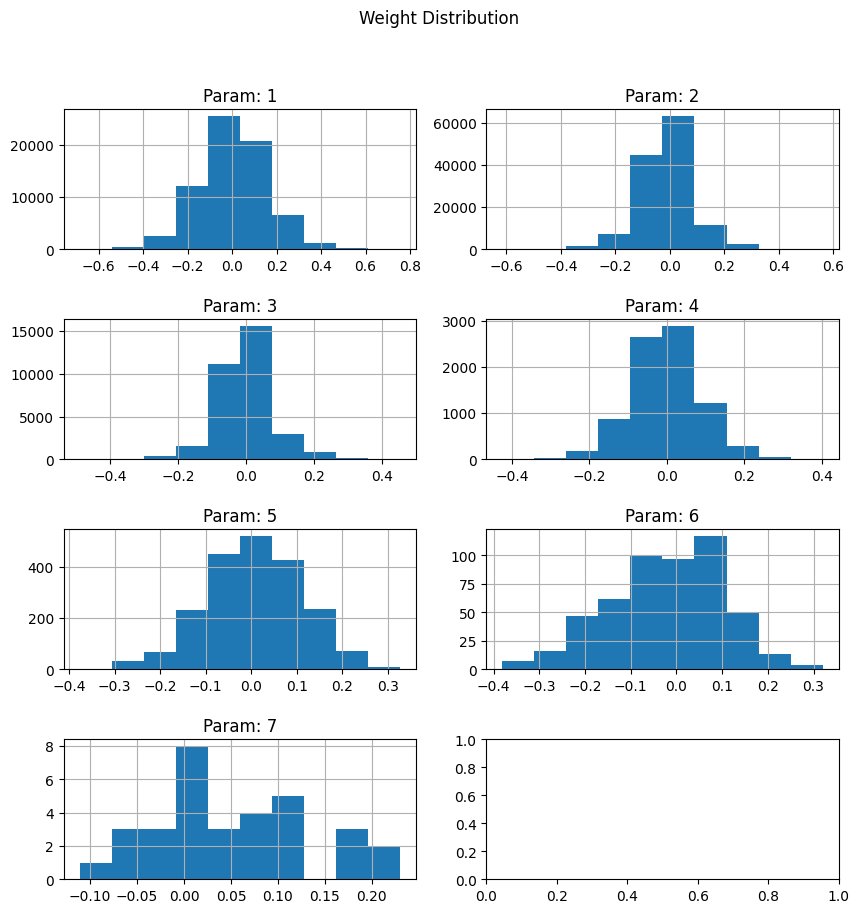

In [44]:
model.show_weight_distribution()

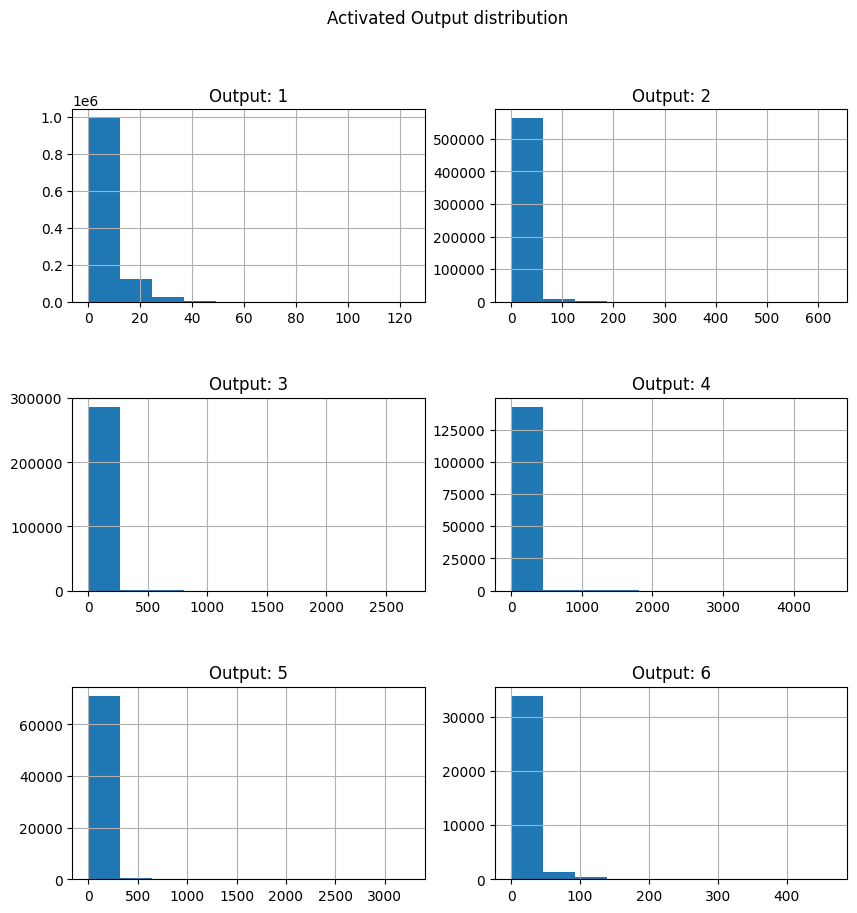

In [45]:
model.show_output_distribution(X_test)

Layer 1 input: torch.Size([2240, 136])
Layer 1 output: torch.Size([2240, 512])
Layer 2 output: torch.Size([2240, 256])
Layer 3 output: torch.Size([2240, 128])
Layer 4 output: torch.Size([2240, 64])
Layer 5 output: torch.Size([2240, 32])
Layer 6 output: torch.Size([2240, 16])
Final output: torch.Size([2240, 2])


Epoch: 49, train loss: 0.17463, Accuracy: 100.000000: 100%|██████████| 50/50 [18:38<00:00, 22.37s/it]


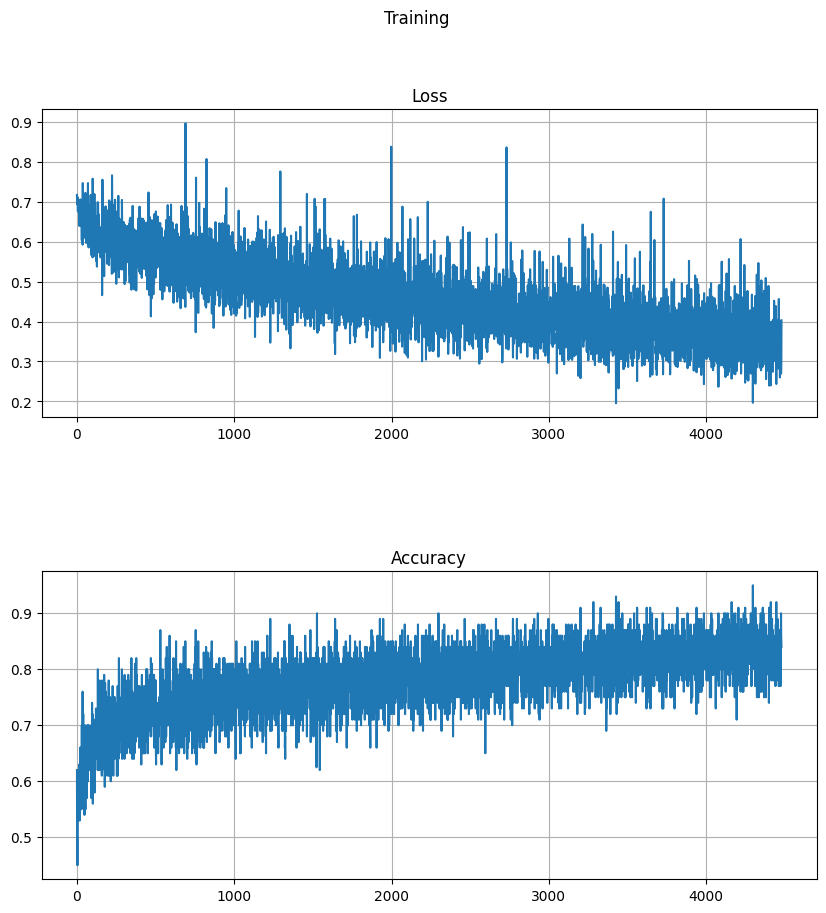

In [46]:
model = ModelDNN(X_test, np.unique(y_test).size, first_layer_neuron=512, hidden_layers_neurons=[256,128, 64, 32, 16])
epochs = 50
batch_size = 2
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=X_train,
    y=y_train,
    print_every=200,
    learning_rate_decay=0.95
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()


In [47]:
with torch.no_grad():
    print(f"Accuracy: {calculate_accuracy(model(X_test), y_test)*100:.3f}%")


Accuracy: 72.991%


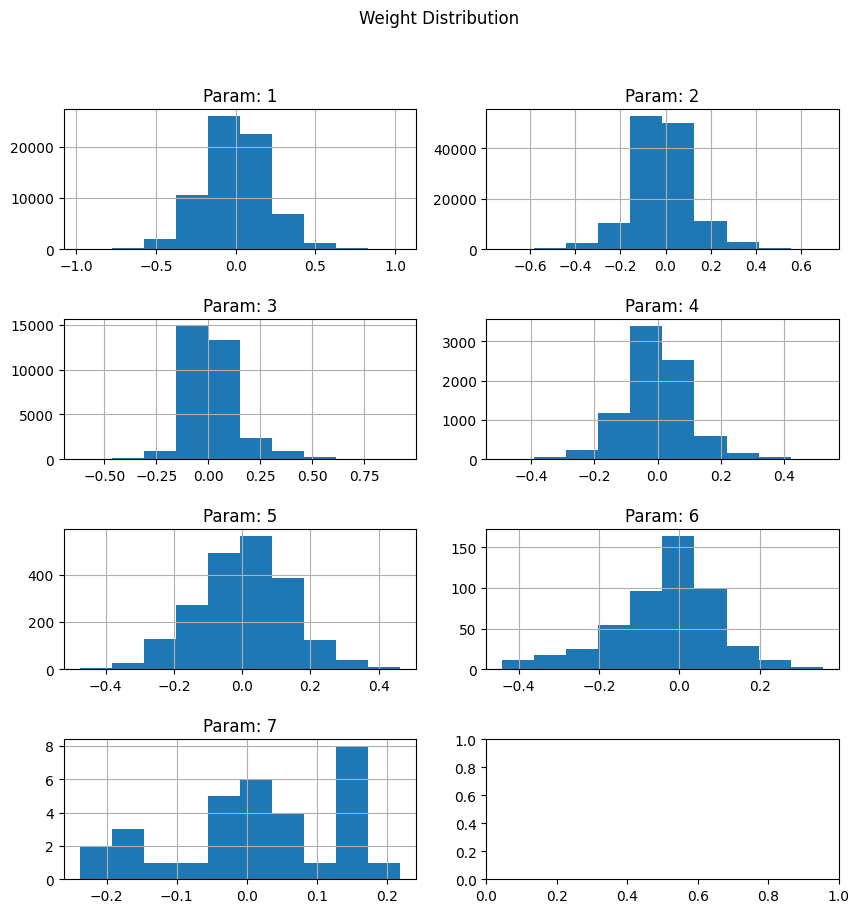

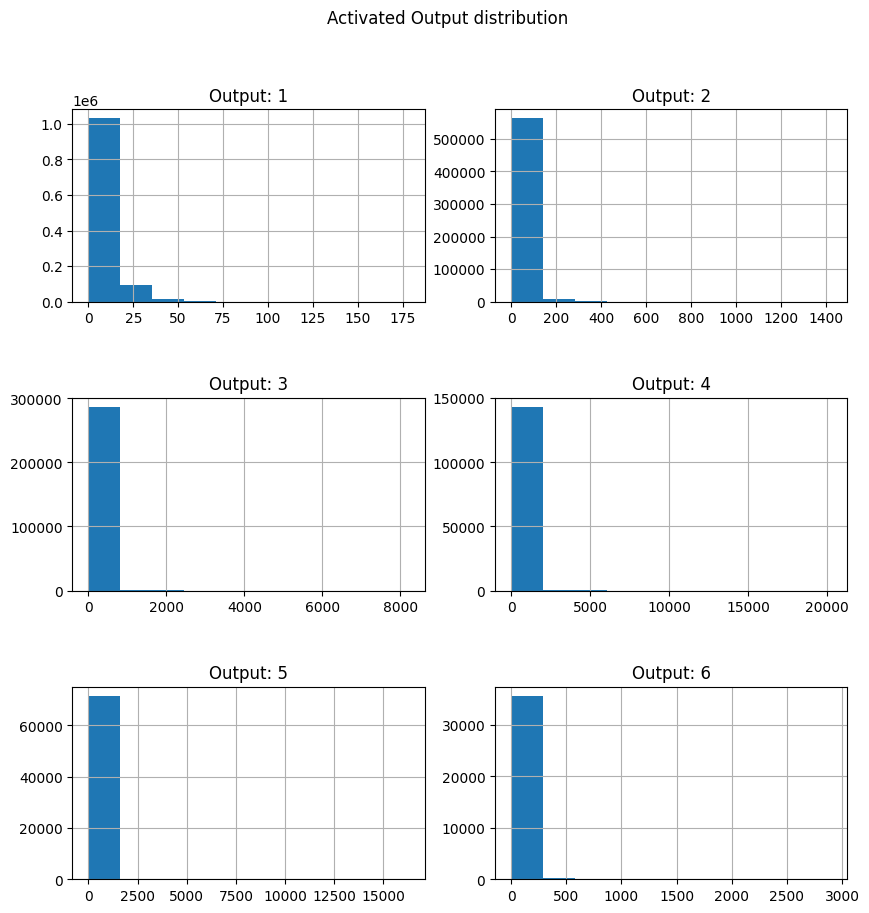

In [48]:
model.show_weight_distribution()
model.show_output_distribution(X_test)

Layer 1 input: torch.Size([2240, 35])
Layer 1 output: torch.Size([2240, 512])
Layer 2 output: torch.Size([2240, 256])
Layer 3 output: torch.Size([2240, 128])
Layer 4 output: torch.Size([2240, 64])
Layer 5 output: torch.Size([2240, 32])
Layer 6 output: torch.Size([2240, 16])
Final output: torch.Size([2240, 2])


Epoch: 49, train loss: 0.15678, Accuracy: 100.000000: 100%|██████████| 50/50 [11:20<00:00, 13.62s/it]


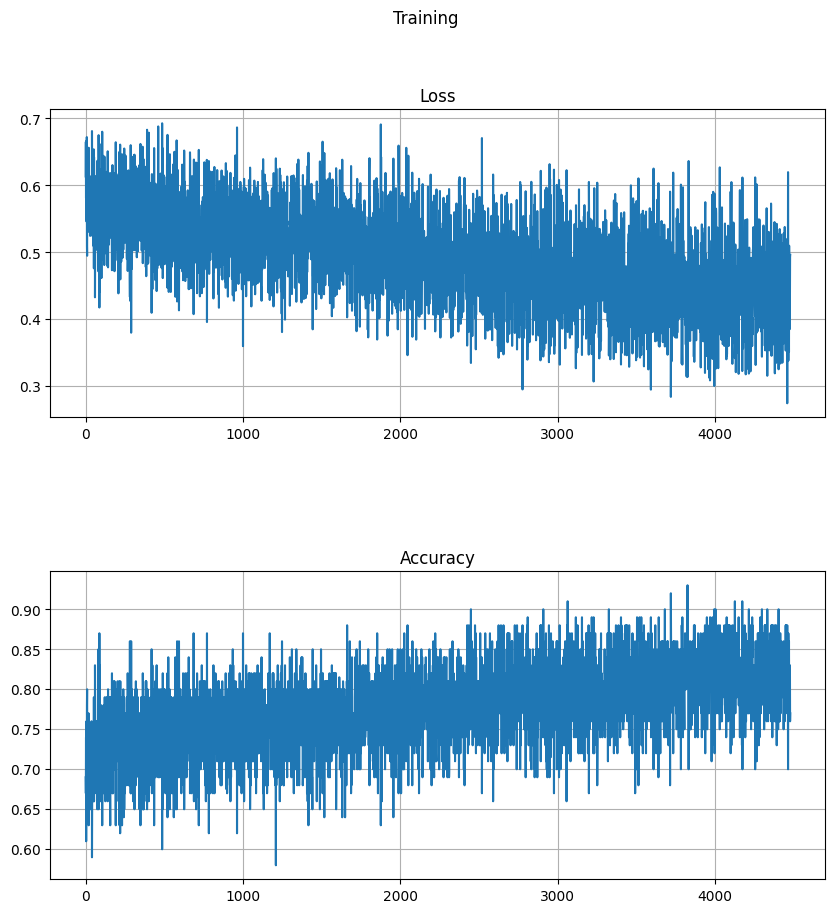

In [49]:
lda = StepwiseLDA(n_components=35)
lda.fit(X_train.numpy(), y_train.numpy())
model = ModelDNN(
    torch.tensor(lda.transform(X_test.numpy()).real).float(), 
    np.unique(y_test.numpy()).size, 
    first_layer_neuron=512, 
    hidden_layers_neurons=[256,128, 64, 32, 16],
    activation=torch.nn.Tanh
)
epochs = 50
batch_size = 2
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=torch.tensor(lda.transform(X_train.numpy()).real).float(),
    y=y_train,
    print_every=200,
    learning_rate_decay=0.95
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()


In [50]:
with torch.no_grad():
    print(f"Accuracy: {calculate_accuracy(model(torch.tensor(lda.transform(X_test.numpy()).real).float()), y_test)*100:.3f}%")


Accuracy: 71.607%


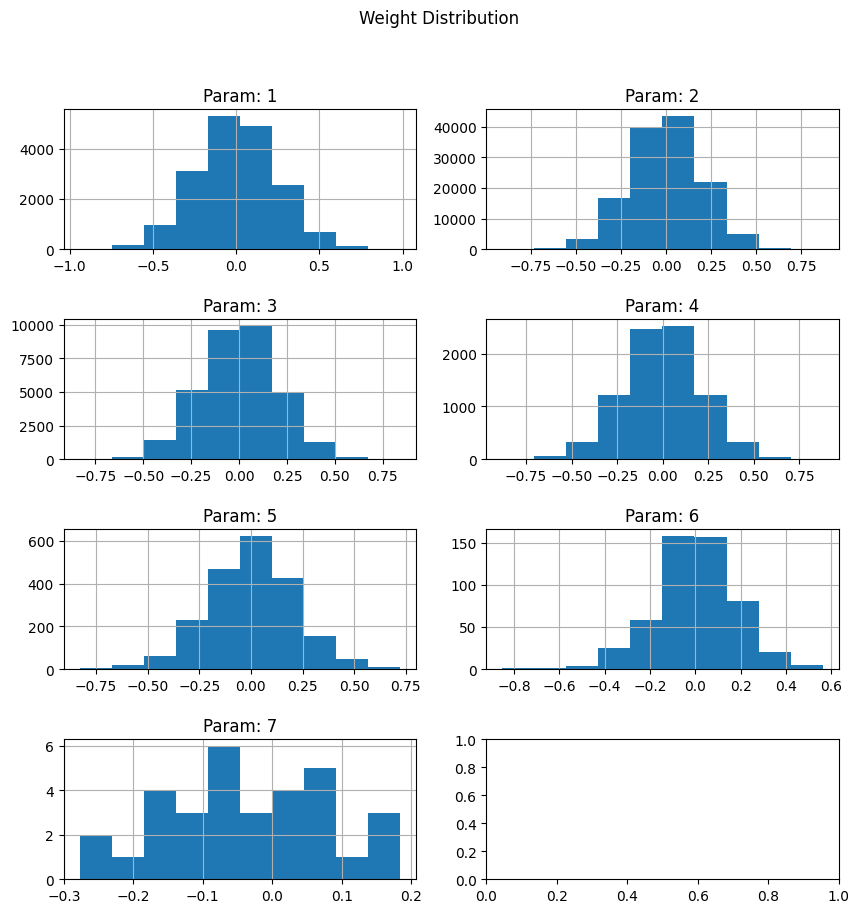

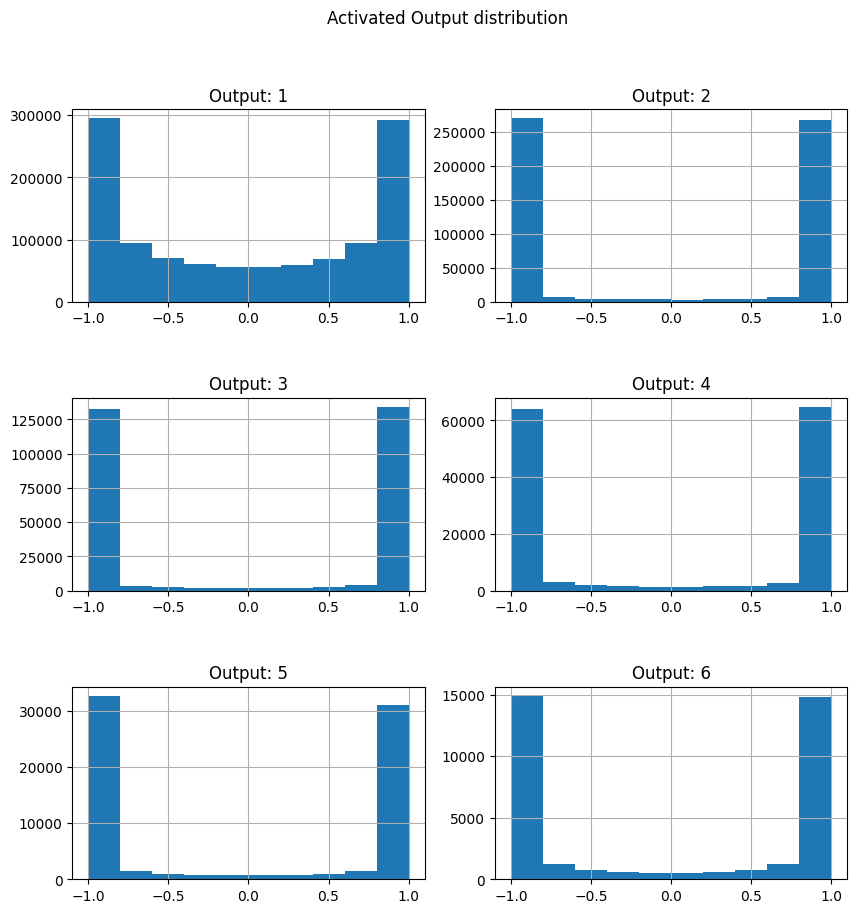

In [51]:
model.show_weight_distribution()
model.show_output_distribution(torch.tensor(lda.transform(X_test.numpy()).real).float())
